In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

plt.style.use('intuitivebayes.mplstyle')
figsize = (25,9)

In [3]:
import pymc.sampling_jax

In [5]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

# Section 30: Art different way
There's more than one way to draw a curve

## Fitting a line
** Fix legend n here**

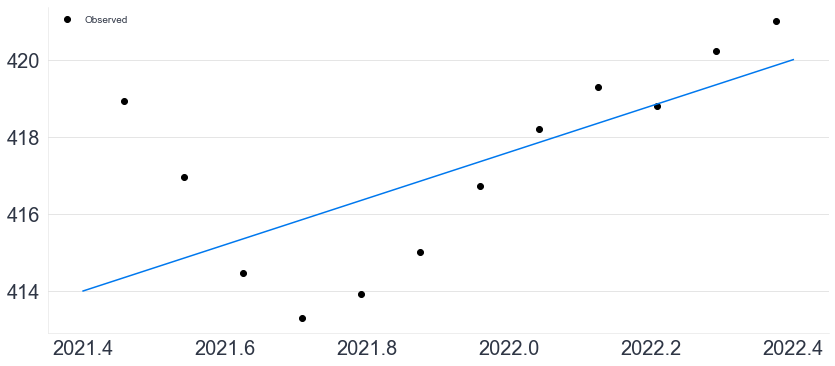

In [85]:
year = data.sort_values("decimal date").tail(12)

def plot_data():
    plt.figure(figsize=(14,6))
    plt.plot(year["decimal date"], year["average"], "ko", label="Observed")


    # Replace with actual coefficients later
    rise = 6
    min_x, max_x = 2021.4, 2022.4
    run = 2022.4 - min_x

    m = rise/run
    b = year["average"].min()



    return

def plot_best_fit_line():
    
    # Replace with actual coefficients later
    rise = 6
    min_x, max_x = 2021.4, 2022.4
    run = 2022.4 - min_x

    m = rise/run
    b = year["average"].min()
    
    # Line
    x_est = np.linspace(min_x, max_x, 100)
    y_est = m*(x_est - min_x) + 414
    plt.plot(x_est, y_est)
    return
    
plot_data()
plot_best_fit_line()
plt.legend();

In the previous lesson we took a functional approach to drawing curves following these series of steps to draw strict lines

## But think about what we're doing

<Figure size 1008x432 with 0 Axes>

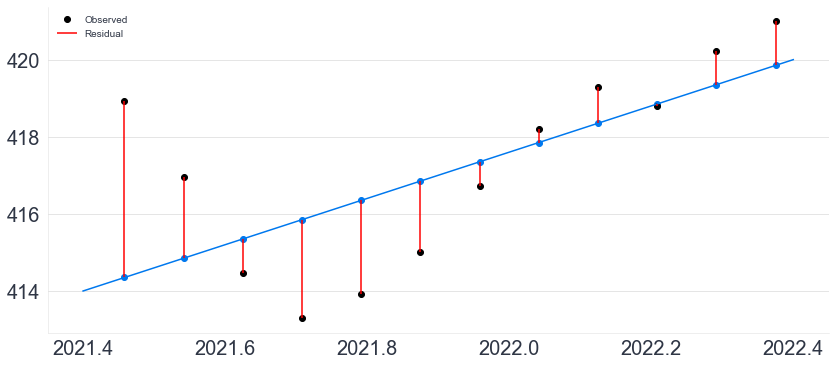

In [87]:
plt.figure(figsize=(14,6))

plot_data()
plot_best_fit_line()

# Plot Residuals
y_est_obs = m*(year["decimal date"] - min_x) + 414

for x, y_obs, y_est in zip(year["decimal date"].values, y_est_obs, year["average"]):
    if x == year["decimal date"].min():
        label = "Residual"
    else:
        label= ""
    plt.vlines(x, np.min([y_obs, y_est]), np.max([y_obs, y_est]), label=label, color="r")

plt.scatter(year["decimal date"], y_est_obs);


plt.legend();

1. Defined a function
2. Listed the parameters
3. Figured out the way to get the "best" parameters given **all** the observed data
  * Minimizing sum of least squares
  * Using Bayesian estimation (which is basically the same thing)
  


## Estimating a point for 2022

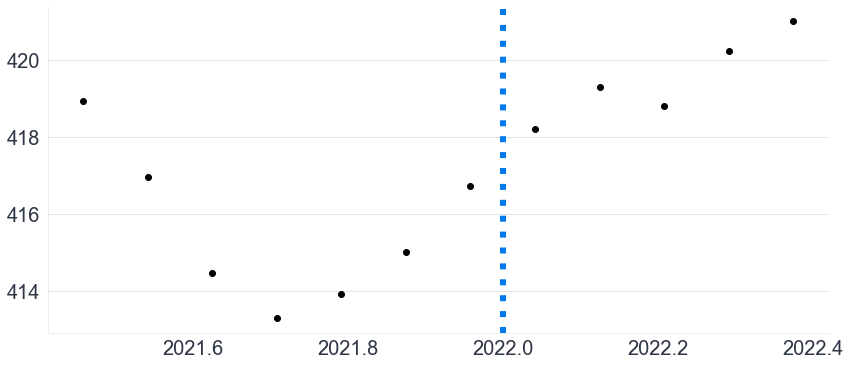

In [96]:
plot_data()
plt.axvline(2022, linestyle="dotted", lw=6)

Let's just focus on one date. 2022.00. If we needed pick a point for this what where would we put it?

If we use our previous approach, since were just minimizing sum of squares, the error for this dot way far on the left, can have a greater impact for our prediction at 2022, than the points right next to 2022 our point of interest.

** Fadi highlight dot all the way to the left, and then

## Some sample points
Here's 4 proposals, there's nothing special about them, we're just picking these four to be concrete.

If we look at them, this one feels "too high", "this one" feels too low, these two seems the most plausible but this one seems right

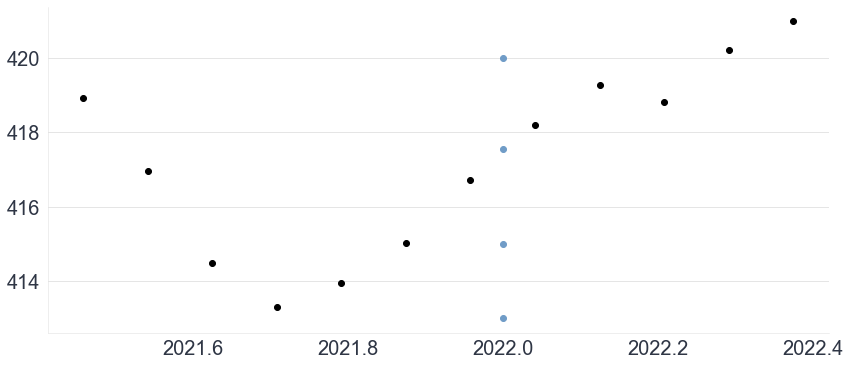

In [105]:
plot_data()

y_vals = (413, 415, 417.45, 420)

for y_val in y_vals:
    plt.plot(2022, y_val, marker="o", c="C5")

## What did we do here
Our guess is you took a look at the points that were closest to 2022 and "eyed out" where the correct placement was.

Importantly our guess is you *did not* consider these other points here

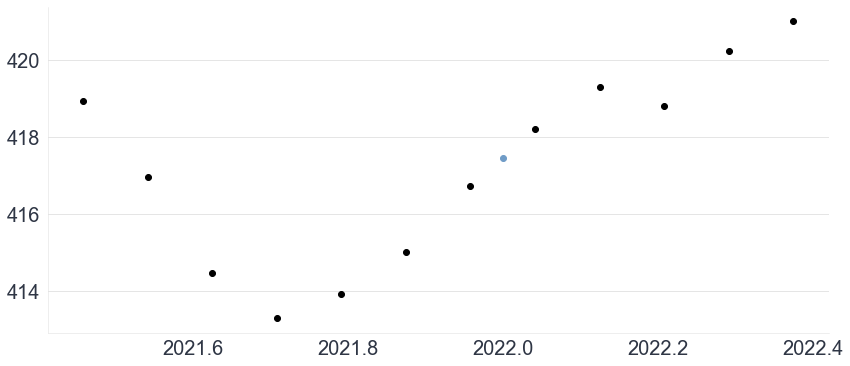

In [117]:
plot_data()
plt.plot(2022, 417.45, marker="o", c="C5");

## Formalizing our intuition

In [124]:
(year
    .assign(distance=np.abs(year["decimal date"] - 2022))
    .sort_values("distance")
    .head(2)
    ["average"].mean())

417.45

Because were mathematicians we can formalize this. We can take the values of the two points closest and take the average to figure out the y distance.

LEts do that again here for this point and this point. So far so good right! 

Writing down our steps.

1. Look at the two closest points
2. Take the average

##  Freeing ourselves of the functional form
This is amazing now we dont need to define a functional form. This method should work equally well on any arbitrary function. Lets now extend

## Something seems off
But when we extend this to all X we get this. Now there is nothing mathematically wrong with this, this is called a windowed average and its very useful in many types of models, but its not exactly what we were hoping to get.

To make this concrete again lets focus back around 2022

## One point should matter more than the other

As we move closer to the dot on the right, we'd assume that our estimated points would go up, since the dot on the right "matters more" as its closer. But because were just selecting the two closest points and averaging that doesn't work




## And what about all the other data points?
You might say, why only two closet data points were throwing away information. Youre right we are and its a problem. But picking the 3, or 4 closest points, and 10 data points and see what happens. We made an exercise so be sure to do it to see what were talking about 

But for now here's a spoiler, in the next section we'll show you how to overcome this challenge. So with that lets go to the section recap

## Section Recap
* There are ways to find that are *not* optimizing over hand selected functional models
  * In this paradigm every data point whether close or far to a particular x value has the same weight
* Intuitively it makes sense that closer observed data should be more influential
* Windowed averaging is one method
  * Works great when the x value of interest is at the midpoint of two observations
  * Does not work so great when we start moving closer to one point or another

## Section 40: SImilarity Functions
The best of both worlds

* So we saw that averaging doesnt work and we need to weight the data somehow. Lets try this weighting function
* Wow this is so cool see how well it does so awesome
* But is this a GP? Turns out it isnt. This kernel estimator while good has a couple of issues,
 * such as lacking uncertainty
 * Something Else
 * Something else

* A full GP solves those issues
* What a full GP would look like is this but as you can see there's a lot more going on. Thatll be for the next lesson

# Art class lesson recap
* Functional forms are great people use them all the time
  * but you gotta figure out the function
  * There might not be a function that fits your data
* Its much more intuitive to use the closest data points to draw a line.
* Moving average is one way to do that but it has challenges
* Kernels let us weight data point which is great but again is lacking in some ways
* GPs solve all these issues